# Определение перспективного тарифа для телеком-компании

## Предобработка данных

In [1]:
# импорт библиотек и читаю таблицы
import pandas as pd
pd.set_option('display.float_format', '{:,.2f}'.format)
from datetime import datetime, timedelta
import numpy as np
from scipy import stats as st
import seaborn as sns
import math
from matplotlib import pyplot as plt

In [2]:
calls, internet, messages, tariffs, users = (
        pd.read_csv('/datasets/calls.csv', parse_dates=['call_date']),
        pd.read_csv('/datasets/internet.csv', parse_dates=['session_date']),
        pd.read_csv('/datasets/messages.csv', parse_dates=['message_date']),
        pd.read_csv('/datasets/tariffs.csv'),
        pd.read_csv('/datasets/users.csv', parse_dates=['reg_date', 'churn_date']),
)

In [3]:
def get_info(df):
    display(df.info(), df.head(3), df.isnull().sum(), df.duplicated().sum())

df_list = [calls, internet, messages, users, ]
for i in df_list: 
    get_info(i)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


None

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000


id           0
call_date    0
duration     0
user_id      0
dtype: int64

0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Unnamed: 0    149396 non-null  int64         
 1   id            149396 non-null  object        
 2   mb_used       149396 non-null  float64       
 3   session_date  149396 non-null  datetime64[ns]
 4   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


None

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,"1,052.81",2018-09-07,1000
2,2,1000_2,"1,197.26",2018-06-25,1000


Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


None

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000


id              0
message_date    0
user_id         0
dtype: int64

0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


None

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart


user_id         0
age             0
churn_date    462
city            0
first_name      0
last_name       0
reg_date        0
tariff          0
dtype: int64

0

По тарифному плану Мегалайн у нас всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

Так что с минутами на звонки поступлю так:
1. Округлю все секунды до минут
2. Добавлю отдельно столбец со звонками. каждая строка в calls = один звонок
3. Сгруппирую и посчитаю сумму duration и кол-во звонков за месяц
4. Прибавлю звонки к минутам

In [4]:
# считаю количество сделанных звонков и израсходованных минут разговора по месяцам
calls['duration'] = np.ceil(calls['duration'])
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls['calls_per_month'] = 1
calls = calls.groupby(['user_id', 'month']).agg({'duration': 'sum', 'calls_per_month': 'sum'}).reset_index()

In [5]:
# считаю количество отправленных сообщений по месяцам
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
messages['messages_per_month'] = 1
messages = messages.groupby(['user_id', 'month']).agg({'messages_per_month': 'sum'}).reset_index()

# считаю объем израсходованного интернет-трафика по месяцам
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
internet = internet.groupby(['user_id', 'month']).agg({'mb_used': 'sum'}).reset_index()

In [6]:
# округляю мегабайты до 1000
def roundup(row_values):
    return int(math.ceil(row_values / 1024))
internet = internet.rename(columns={'mb_used': 'gb_used'})
internet['gb_used'] = internet['gb_used'].apply(roundup)
internet.head()

,user_id,month,gb_used
0,1000,5,3
1,1000,6,23
2,1000,7,14
3,1000,8,14
4,1000,9,15


### Обьеденение таблиц и подсчет месячной выручки тарифов

In [7]:
# обьеденяю обновленные таблицы с помощью `merge`
df = calls.merge(messages, on=['user_id','month'], how = 'outer')
df = df.merge(internet, on=['user_id','month'], how = 'outer')
df = df.merge(users, on=['user_id'], how = 'outer')

# переименовываю столбец tariff, а то не смерджить таблицы
df = df.rename(columns = {'tariff' : 'tariff_name'})
df = df.merge(tariffs, on=['tariff_name'])

# удаляем тех пользователей, которые прекратили пользоваться тарифом
df = df.query('churn_date == "NaN"')

In [8]:
# считаем овердрафты тарифов
df['minutes_over'] = (df['duration'] - df['minutes_included']) *  df['rub_per_minute']
df['messages_over'] = (df['messages_per_month'] - df['messages_included']) *  df['rub_per_message']
df['gb_used_over'] = ((df['gb_used'] - df['mb_per_month_included']/1024)) *  df['rub_per_gb']

# убираем отрицательные овердрафты
df.loc[df['minutes_over'] < 0, 'minutes_over'] = 0
df.loc[df['messages_over'] < 0, 'messages_over'] = 0
df.loc[df['gb_used_over'] < 0, 'gb_used_over'] = 0

# уберем NaN значения, а то они мешают считать итоговую выручку
df['minutes_over'] = df['minutes_over'].replace(np.nan, 0)
df['messages_over'] = df['messages_over'].replace(np.nan, 0)
df['gb_used_over'] = df['gb_used_over'].replace(np.nan, 0)

# считаем месячную выручку с каждого пользователя
df['total_bill'] = (df['minutes_over'] + df['messages_over'] + df['gb_used_over'] + df['rub_monthly_fee'])

## Анализ и описание данных

### Анализ тарифов

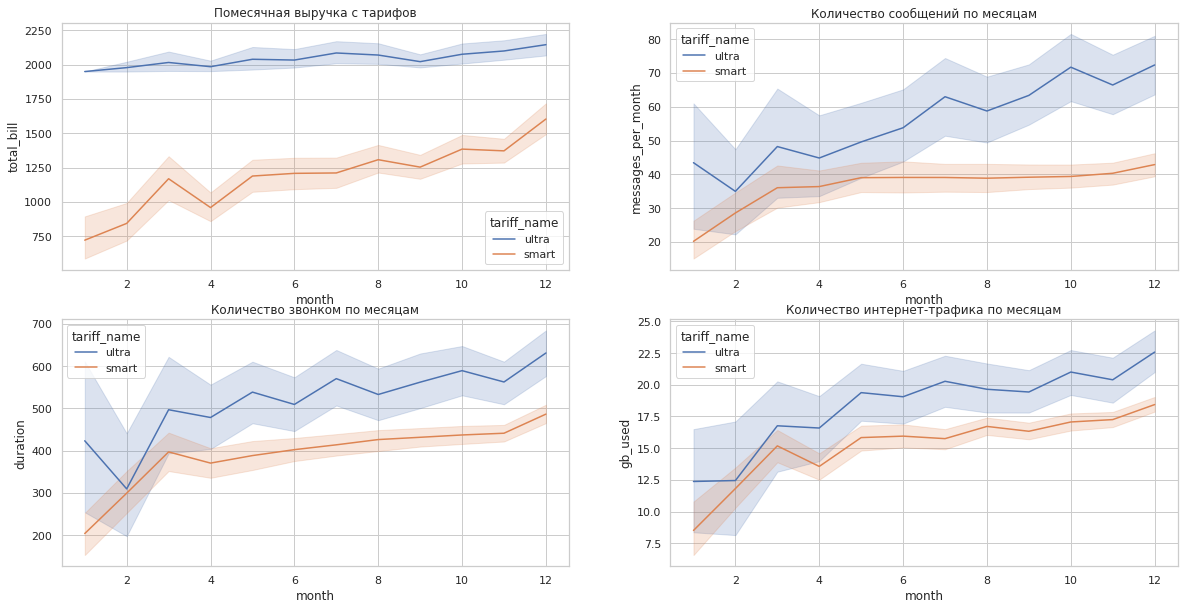

In [9]:
# анализ тарифов
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
sns.lineplot(ax=axes[0, 0], data=df, x="month", y="total_bill", hue="tariff_name").set_title("Помесячная выручка с тарифов")
sns.lineplot(ax=axes[1, 0], data=df, x="month", y="duration", hue="tariff_name").set_title("Количество звонком по месяцам")
sns.lineplot(ax=axes[0, 1], data=df, x="month", y="messages_per_month", hue="tariff_name").set_title("Количество сообщений по месяцам")
sns.lineplot(ax=axes[1, 1], data=df, x="month", y="gb_used", hue="tariff_name").set_title("Количество интернет-трафика по месяцам")
plt.show()

### Анализ выручки

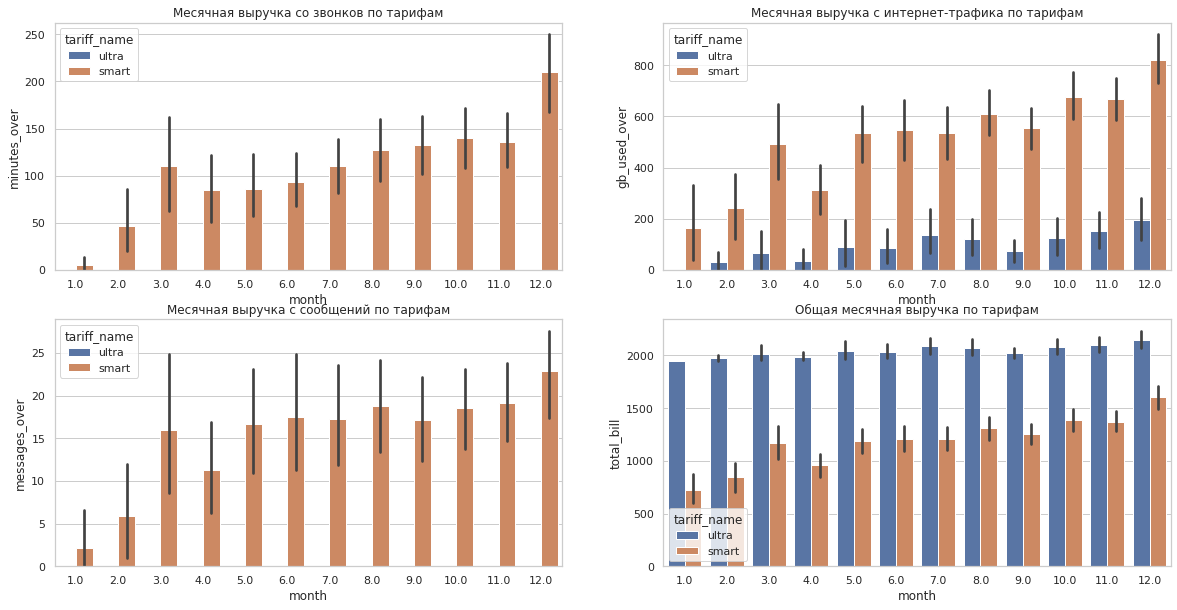

In [10]:
# анализ тарифов
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
sns.barplot(ax=axes[0, 0], data = df, x="month", y="minutes_over", hue="tariff_name").set_title("Месячная выручка со звонков по тарифам")
sns.barplot(ax=axes[1, 0], data = df, x="month", y="messages_over", hue="tariff_name").set_title("Месячная выручка с сообщений по тарифам")
sns.barplot(ax=axes[0, 1], data = df, x="month", y="gb_used_over", hue="tariff_name").set_title("Месячная выручка с интернет-трафика по тарифам")
sns.barplot(ax=axes[1, 1], data = df, x="month", y="total_bill", hue="tariff_name").set_title("Общая месячная выручка по тарифам")
plt.show()

In [11]:
# считаю дисперсию
np.var(df[['messages_per_month', 'duration', 'gb_used', 'total_bill']], ddof=1)

messages_per_month     1,255.06
duration              56,870.48
gb_used                   52.72
total_bill           637,319.47
dtype: float64

In [12]:
# узнаю среднее количество сообщений, минут разговора и обьем интернет трафика по разным тарифам
df.groupby('tariff_name').agg({'messages_per_month':'mean', 'duration': 'mean', 'gb_used': 'mean'})

,messages_per_month,duration,gb_used
tariff_name,,,
smart,39.00,423.97,16.40
ultra,61.83,552.60,19.81


In [13]:
# считаю стандратное отклонение
np.sqrt(np.var(df[['messages_per_month', 'duration', 'gb_used', 'total_bill']], ddof=1))

messages_per_month    35.43
duration             238.48
gb_used                7.26
total_bill           798.32
dtype: float64

In [14]:
# считаю стандартное отклонение по тарифам
df.groupby('tariff_name').agg({'messages_per_month':'std', 'duration': 'std', 'gb_used': 'std'}).reset_index()

,tariff_name,messages_per_month,duration,gb_used
0,smart,26.98,190.14,5.70
1,ultra,46.53,308.65,9.60


### Вывод

По графикам видно:
1. Кол-во сообщений/звонков/интернет-трафика в тарифе `ultra` используется больше, чем в тарифе `smart`. 
2. Месячная выручка c сообщений/звонков/интернет-трафика в тарифе `smart` выше. Видимо в ультре всем хватает лимитов и никто не переплачивает (только по интернет-трафику пользователеям ультры все же чуть не хватает..).
3. Общая месячная выручка у тарифа `ultra` выше. Видимо за счет ежемесячной абонентской платы.

## Проверка гипотез и пояснения

### Проверка гипотезы: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

In [15]:
# создаю два списка с месячными платежами по тарифам
smart_bills = df[df['tariff_name'] == 'smart']['total_bill']
ultra_bills = df[df['tariff_name'] == 'ultra']['total_bill']

In [16]:
# проверяю гипотезу через t-test
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.ttest_ind(smart_bills, ultra_bills)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 4.21341783798234e-144
Отвергаем нулевую гипотезу


Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

In [17]:
print('Средняя выручка тарифа Смарт:',int(smart_bills.mean()))
print('Средняя выручка тарифа Ультра:',int(ultra_bills.mean()))

Средняя выручка тарифа Смарт: 1299
Средняя выручка тарифа Ультра: 2066


### Проверка гипотезы: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [18]:
# создаю два списка с месячными платежами по тарифам
bills_moscow = df[df['city'] == 'Москва']['total_bill']
bills_other = df[df['city'] != 'Москва']['total_bill']

In [19]:
# проверяю гипотезу через t-test
city_results = st.ttest_ind(bills_moscow, bills_other)

print('p-значение:', city_results.pvalue)

if city_results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.6177577589717255
Не получилось отвергнуть нулевую гипотезу


Средняя выручка пользователей москвы не отличается от выручки пользоваталей из других регионов.

In [20]:
print('Средняя выручка Москвы:',int(bills_moscow.mean()))
print('Средняя выручка других регионов:',int(bills_other.mean()))

Средняя выручка Москвы: 1545
Средняя выручка других регионов: 1526


In [21]:
# считаю кол-во пользователей по тарифам
df['tariff_name'].value_counts()

smart    2118
ultra     909
Name: tariff_name, dtype: int64

In [22]:
# считаю сколько в среднем тратит пользователь каждого тарифа в месяц по каждой из услуг
df.groupby('tariff_name').agg({'minutes_over':'mean', 'messages_over': 'mean', 'gb_used_over': 'mean'}).reset_index()

,tariff_name,minutes_over,messages_over,gb_used_over
0,smart,130.16,17.82,601.51
1,ultra,0.00,0.00,117.00


In [23]:
# считаю стандартное отклонение по тарифам
df.groupby('tariff_name').agg({'messages_per_month':'std', 'duration': 'std', 'gb_used': 'std'}).reset_index()

,tariff_name,messages_per_month,duration,gb_used
0,smart,26.98,190.14,5.70
1,ultra,46.53,308.65,9.60


### Вывод

1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.
2. Средняя выручка пользователей москвы не отличается от выручки пользоваталей из других регионов.

## Общий вывод

1. Пользоваталей в тарифе `smart` в 2.3 раза больше , чем в тарифе `ultra.` (т.е. для ультры есть куда еще расти)
2. Дисперсия по каждой из услуг тарифа `ultra` выше, чем у тарифа `smart`, это означает, что пользователи ультры более склонны слать больше смс/звонить/пользоваться интернет-трафиком.
3. Средняя выручка по месяцам же у тарифа `ultra` выше, чем у `smart`.
<br><br>
Вывод: тарифа `ultra` приносит больше денег, коммерческому департаменту стоит сфокусироваться на нем.